# PRONOSTICO DE DEMANDA CON PYTHON




## PASAJEROS DEL SISTEMA DE TRANSPORTE PUBLICO DE PORTLAND

### LOS DATOS

Los datos representan un conteo mensual de pasajeros para el sistema de transporte público de Portland.
La información es desde Enero del 1971 hasta Junio de 1982.

### EL PROCESO
![image](proceso.png)

### Importamos las librerías

In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### Importamos los datos de venta

In [36]:
df = pd.read_excel("pasajeros.xlsx", sheet_name=0, index_col=0)
df.index.name=None
df.columns= ['pasajeros']
print(df.head())

            pasajeros
1960-02-01        646
1960-03-01        639
1960-04-01        654
1960-05-01        630
1960-06-01        622


## Visualizar los datos

Visualizamos los datos para poder identificar que modelo debemos usar.
* Existe una tendencia en los datos?
* Existe una estacionalidad en los datos?

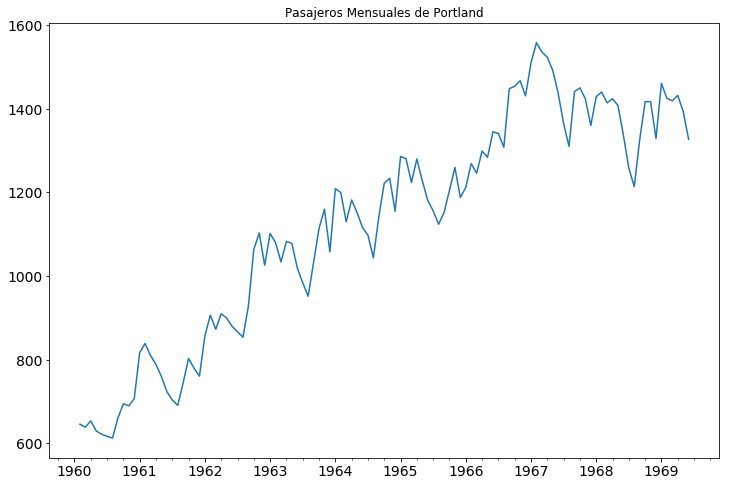

In [38]:
df.pasajeros.plot(figsize=(12,8), title= 'Pasajeros Mensuales de Portland', fontsize=14)
plt.savefig('pasajeros.png', bbox_inches='tight')

La información tiene una clara tendencia, esto nos sugiere que la serie NO es estacionaria y por lo tanto, requiere diferenciarla para hacerla estacionaria.

Otra herramienta para visualizar los datos es la función de descomposición estacional en la librería *statsmodel*; la función permite evidenciar la tendencia y la estacionalidad.

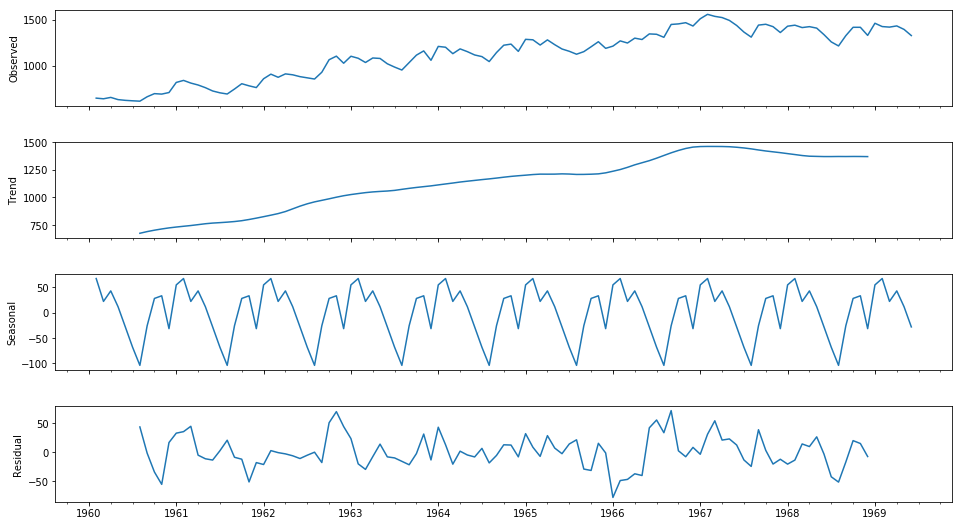

In [39]:
decomposition = seasonal_decompose(df.pasajeros, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

Los valores residuales eliminan esencialmente la tendencia y la estacionalidad de los datos, lo que hace que los valores sean independientes del tiempo. Podría tratar de modelar los residuos usando variables exógenas, pero podría ser difícil intentar volver a convertir los valores residuales pronosticados en números significativos.

## Estacionarizar los datos

¿Qué significa que los datos sean estacionarios?

1. La media de la serie no debe ser una función del tiempo.
2. La varianza de la serie no debe ser una función del tiempo. Esta propiedad se conoce como homocedasticidad.
3. Finalmente, la covarianza del primer término y el término (i + m) no deberían ser una función del tiempo.

¿Porque es esto importante? Cuando se ejecuta una regresión lineal, se supone que todas las observaciones son independientes entre sí. En una serie de tiempo, sin embargo, sabemos que las observaciones dependen del tiempo. Resulta que muchos buenos resultados que se mantienen para variables aleatorias independientes (ley de grandes números y teorema del límite central para nombrar un par) se mantienen para las variables estacionarias aleatorias. Entonces al hacer los datos estacionarios, podemos aplicar técnicas de regresión a esta variable dependiente del tiempo.

Hay dos caminos de verificar la estacionalidad de una serie temporal. El primero es mirando los datos. Al visualizar los datos, debería ser fácil identificar un cambio de media o variación en los datos. Para una evaluación más precisa, está la prueba Dickey-Fuller. Si la "Prueba Estadística" es mayor que el "valor crítico", la serie de tiempo es estacionaria. A continuación hay un código que te ayudará a visualizar las series de tiempo y probar la estacionalidad.

In [57]:
from statsmodels.tsa.stattools import adfuller
def prueba_estacionaridad(series):

    #Determinamos las estadísticas medía y desviación
    rolmean = series.rolling(window=12, center=False).mean()
    rolstd = series.rolling(window=12, center=False).std()

    #Graficamos las estadísticas:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(series, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Media')
    std = plt.plot(rolstd, color='black', label = 'Rolling Desviación')
    plt.legend(loc='best')
    plt.title('Rolling de la Media & Desviación Estándar')
    plt.show()
    
    #Realizar la prueba Dickey-Fuller:
    print('Resultadoss de la prueba Dickey-Fuller:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Prueba Estadística','p-value','#Períodos Usados','Número de observaciones usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)

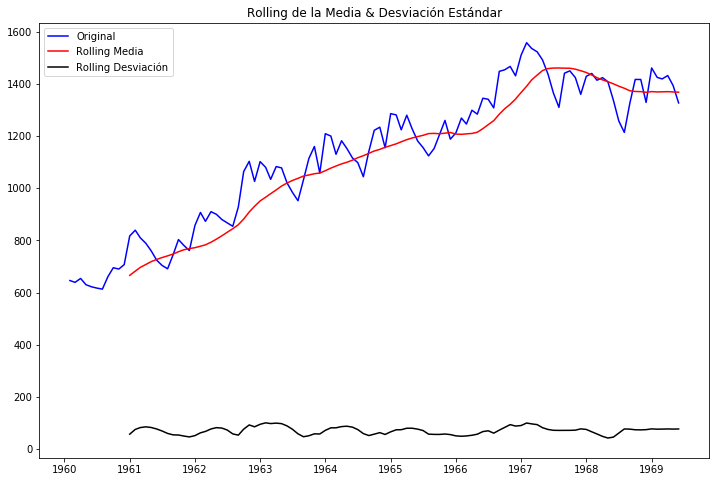

Resultadoss de la prueba Dickey-Fuller:
Prueba Estadística                 -1.431842
p-value                             0.566919
#Períodos Usados                   12.000000
Número de observaciones usadas    100.000000
Valor crítico (1%)                 -3.497501
Valor crítico (5%)                 -2.890906
Valor crítico (10%)                -2.582435
dtype: float64


In [58]:
prueba_estacionaridad(df.pasajeros)

Ahora necesitamos transformar los datos para hacerlo más estacionario. Hay varias transformaciones que puede hacer para estabilizar los datos.

* Deflación por CPI
* Logarítmico
* Primera diferencia
* Diferencia estacional
* Ajuste estacional

Lo primero que debemos hacer es tomar una primera diferencia de los datos. Esto debería ayudar a eliminar la tendencia general de los datos.

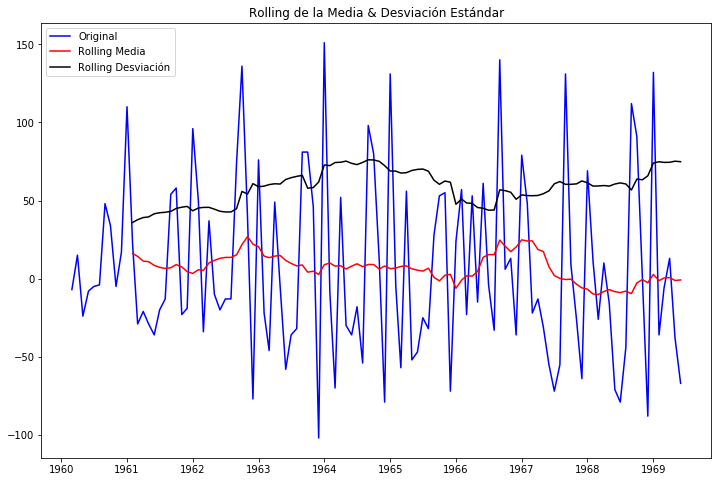

Resultadoss de la prueba Dickey-Fuller:
Prueba Estadística                 -1.983904
p-value                             0.293675
#Períodos Usados                   11.000000
Número de observaciones usadas    100.000000
Valor crítico (1%)                 -3.497501
Valor crítico (5%)                 -2.890906
Valor crítico (10%)                -2.582435
dtype: float64


In [59]:
df['primera_diferencia'] = df.pasajeros - df.pasajeros.shift(1)  
prueba_estacionaridad(df.primera_diferencia.dropna(inplace=False))

Si bien esto ayudó a mejorar la estacionalidad de los datos, aún no es suficiente. Nuestro siguiente paso es tomar una diferencia estacional para eliminar la estacionalidad de los datos y ver cómo eso afecta la estacionalidad de los datos.

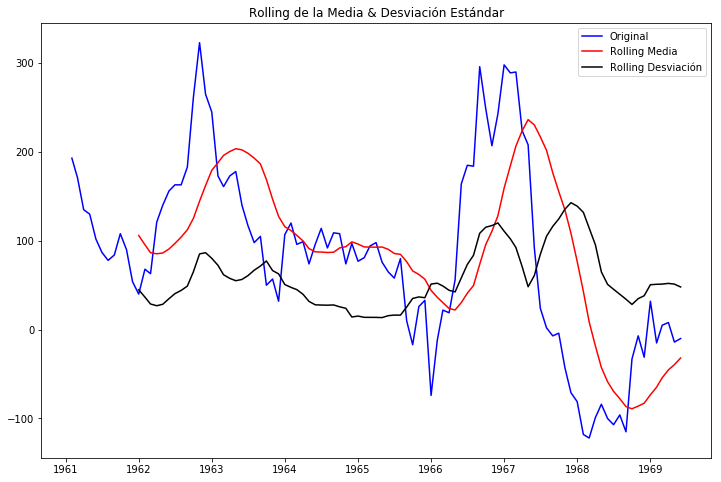

Resultadoss de la prueba Dickey-Fuller:
Prueba Estadística                -2.450859
p-value                            0.127893
#Períodos Usados                   3.000000
Número de observaciones usadas    97.000000
Valor crítico (1%)                -3.499637
Valor crítico (5%)                -2.891831
Valor crítico (10%)               -2.582928
dtype: float64


In [60]:
df['diferencia_estacional'] = df.pasajeros - df.pasajeros.shift(12)  
prueba_estacionaridad(df.diferencia_estacional.dropna(inplace=False))

En comparación con los datos originales, esta es una mejora, pero todavía no hemos llegado. El siguiente paso es tomar una primera diferencia de la diferencia estacional.

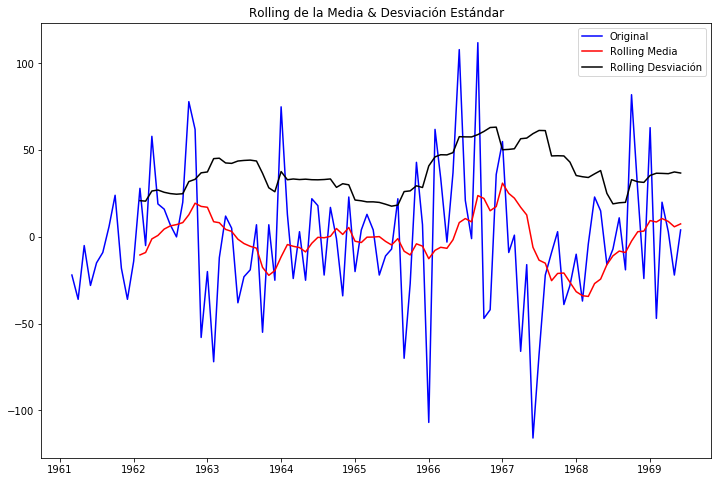

Resultadoss de la prueba Dickey-Fuller:
Prueba Estadística               -9.167777e+00
p-value                           2.434264e-15
#Períodos Usados                  0.000000e+00
Número de observaciones usadas    9.900000e+01
Valor crítico (1%)               -3.498198e+00
Valor crítico (5%)               -2.891208e+00
Valor crítico (10%)              -2.582596e+00
dtype: float64


In [62]:
df['primera_diferencia_estacional'] = df.primera_diferencia - df.primera_diferencia.shift(12)  
prueba_estacionaridad(df.primera_diferencia_estacional.dropna(inplace=False))

Como se puede observar el valor p, tomar la primera diferencia estacional ahora ha hecho que nuestros datos permanezcan estacionarios.

## Graficar los cuadros ACF/PACF y encontrar los parámetros óptimos

El siguiente paso es determinar los parámetros de ajuste del modelo mirando los gráficos de autocorrelación y autocorrelación parcial.
Existen muhcas reglas y buenas prácticas acerca de como seleccionar los términos *AR*, *MA*, *SAR* y *MAR* para el modelo.
El siguiente cuadro proporciona una breve guía sobre cómo leer los gráficos de autocorrelación y autocorrelación parcial para seleccionar los términos adecuados.

A continuación se muestran los gráficos ACF y PACF para los valores de la primera diferencia estacional.

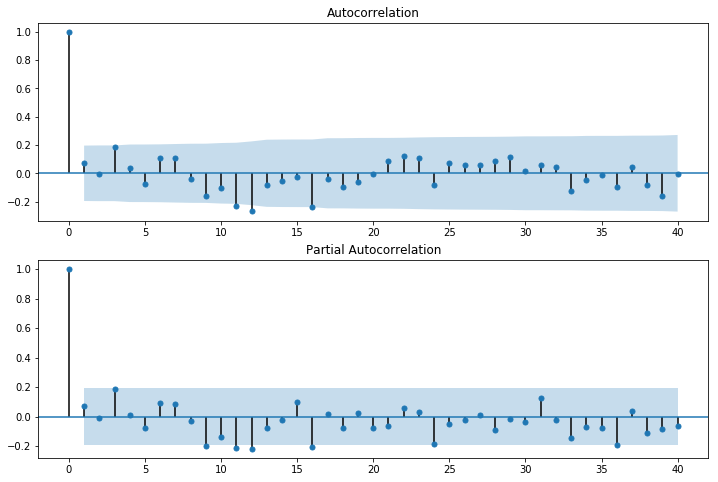

In [63]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.primera_diferencia_estacional.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.primera_diferencia_estacional.iloc[13:], lags=40, ax=ax2)

Debido a que la autocorrelación de la serie diferenciada es negativa en el desfase 12 (un año después), debería incluir un término de SMA para el modelo. Al probar diferentes términos, encuentro que agregar un término SAR mejora la precisión de la predicción.

## Construir el Modelo ARIMA

Ahora que sabemos que necesitamos hacer y los parámetros para el modelo ((0,1,0) x (1,1,1,12), realmente construirlo es bastante fácil.

In [66]:
mod = sm.tsa.statespace.SARIMAX(df.pasajeros, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
resultados = mod.fit()
print(resultados.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          pasajeros   No. Observations:                  113
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -496.800
Date:                            Tue, 06 Mar 2018   AIC                            999.601
Time:                                    14:10:36   BIC                           1007.783
Sample:                                02-01-1960   HQIC                          1002.921
                                     - 06-01-1969                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3256      0.191      1.703      0.089      -0.049       0.700
ma.S.L12      -0.9978     19.457   

## Realizar Predicciones

Ahora que tenemos un modelo creado, queremos usarlo para hacer pronósticos. Primero, estoy usando el modelo para pronosticar períodos de tiempo para los cuales ya tenemos datos, para que podamos entender qué tan precisos son los pronósticos.

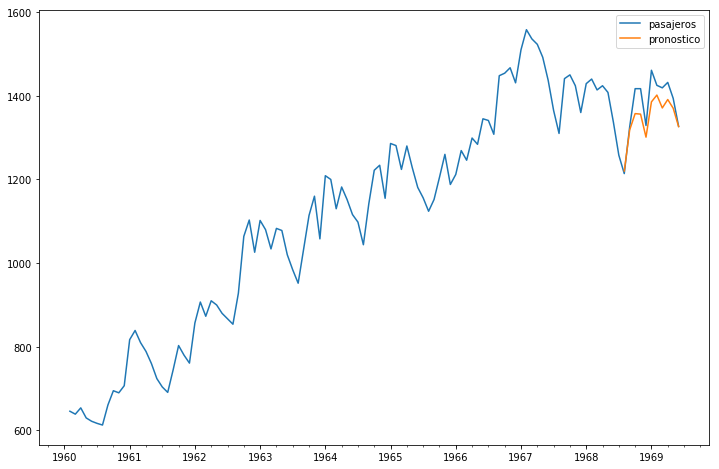

In [67]:
df['pronostico'] = resultados.predict(start = 102, end= 114, dynamic= True)  
df[['pasajeros', 'pronostico']].plot(figsize=(12, 8)) 

A continuación se muestra una visualización que hace que sea más fácil comparar el pronóstico con los resultados reales.

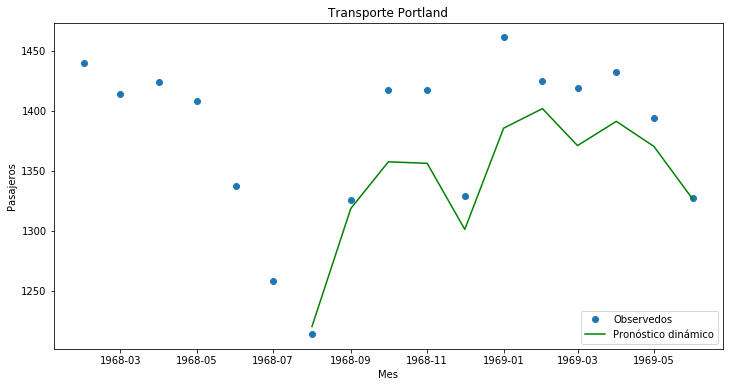

In [75]:
npredict =df.pasajeros['1969'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Transporte Portland', xlabel='Mes', ylabel='Pasajeros')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'pasajeros'], 'o', label='Observedos')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'pronostico'], 'g', label='Pronóstico dinámico')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')